In [1]:
import pandas as pd # Pandas library
import numpy as np # Numpy library
import matplotlib.pyplot as plt # Matplotlib library
import numpy.linalg as la # Linear algebra functions
import math # Math library
import random # Random library
import seaborn as sns # Seaborn library

In [3]:
crime_data = pd.read_csv('./SanFranciscoCrimeDataset/crime.csv',
                          header=1,
                          skipinitialspace=False,
                          names=['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
                                'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'])
crime_data = crime_data[ ~crime_data['PdDistrict'].isna() ]
crime_data.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
1,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
2,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
3,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000
4,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",16000286904134


# Testing Training Difference for KNN Over Time

In [54]:
# KNN Class
class KNN:
    def __init__(self, k):
        self.k = k
        self.trainarr = []
        self.classifier_list = []
        self.predicted_points = []
        
    def distance(self, point):
        """
        Finds the distance of every training set value from point, and then returns the as list of tuples sorted in ascending order 
        by distance values paired with the corresponding "classifier"
        """
#         distance_pairs_list = [(0,0) for _ in range(len(self.trainarr))]
#         for ind,i in enumerate(self.trainarr):
#             distance_pairs_list[ind] = (la.norm(np.array(point) - np.array(i[0])), i[1])
        distance_pairs_list = [(la.norm(np.array(point) - np.array(i[0])), i[1]) for i in self.trainarr]
        distance_pairs_list.sort(key= lambda x: x[0])
        return distance_pairs_list
    
    def train(self, tlist):
        """
        Takes a list of training data => tuple containing a samples X ndims list and it's associated classifier 
        that will be stored for later
        """
        self.trainarr = tlist[:]
        self.classifier_list = list(set([i[1] for i in self.trainarr]))
        
    def predict(self, point, graphing=False):
        """ 
        Point must be a list, same dimension as the training set
        graphing is default False (for efficiency), otherwise True adds point to list for graphing later
        """
        classifier_counts = {i[1]: 0 for i in self.trainarr}
        distance_list = self.distance(point)
        key_select = ''
        for index,item in enumerate(distance_list):
            if index < self.k:
                classifier_counts[item[1]] += 1
            else:
                #max_dict_val = max([value for key,value in classifier_counts.items()])
                max_dict_val = max(classifier_counts.values())
                #max_dict_val = max(classifier_counts, key=classifier_counts.get)
                if list(classifier_counts.values()).count(max_dict_val) > 1:
                    classifier_counts[item[1]] += 1
                else:
                    for key, value in classifier_counts.items():
                        if value == max_dict_val:
                            key_select = key
                            break
                    break
        #print(f'I am predicting that the classifier for point {point} is... {key_select}!')
        if graphing:
            self.predicted_points.append((point, key_select))
        return key_select
        
    def plot_train(self):
        """
        Can only plot for 2d data
        """
        colors = ['Green', 'Red', 'Blue', 'Black', 'Yellow', 'Pink', 'Brown', 'Purple']
        for ind, item in enumerate(self.classifier_list):
            plotx = [j[0][0] for j in self.trainarr if j[1] == item]
            ploty = [j[0][1] for j in self.trainarr if j[1] == item]
            plt.scatter(x=plotx, y=ploty, c=colors[ind], label=item)
        plt.title('Plot of sample training data')
        plt.legend()
        plt.xlabel('X axis')
        plt.ylabel('Y axis')
        plt.show()
        
    def plot_train_and_predictions(self):
        """
        Can only plot for 2d data, plots the point that was predicted
        """
        colors = ['Green', 'Red', 'Blue', 'Black', 'Yellow', 'Pink', 'Brown', 'Purple']
        for ind, item in enumerate(self.classifier_list):
            plotxtrain = [j[0][0] for j in self.trainarr if j[1] == item]
            plotytrain = [j[0][1] for j in self.trainarr if j[1] == item]
            plotxpredict = [j[0][0] for j in self.predicted_points if j[1] == item]
            plotypredict = [j[0][1] for j in self.predicted_points if j[1] == item]
            plt.scatter(x=plotxtrain, y=plotytrain, c=colors[ind], label=f'Trained: {item}')
            plt.scatter(x=plotxpredict, y=plotypredict, c=colors[ind], label=f'Predicted: {item}', marker='^')
        plt.title(f'Plot of sample training data and predicted points (k = {self.k})')
        plt.legend()
        plt.xlabel('X axis')
        plt.ylabel('Y axis')
        plt.show()

In [55]:
# split_sets Function
def split_sets(dataframe, train_p):
    """
    Returns 2 lists of the form needed to use the KNN class using the San Francisco Crime dataset
    -- The function uses x and y coordinate data for graphing and the type of crime as our labels.
    **The dataframe passed can be subset to go by location to see how KNN works on each "area"
    """
    assert(train_p < 1) # Make sure that p is a percentage
    assert(train_p > 0) # Make sure that p is non-negative
    
    # Split dataframe into training and test/prediction sets
    train_count = int(dataframe.shape[0] * train_p)
    predict_count = int(dataframe.shape[0] * (1 - train_p))
    
    #tmp_list = dataframe.values
    
    tmp_list = dataframe.values[:]
    np.random.shuffle(tmp_list) # Shuffle the rows
    train_list = tmp_list[0:train_count] # Take the first train_p percentage for the training data
    predict_list = tmp_list[train_count:] # The rest go to predict data
    
    rtn_train = [([i[1], i[2]], i[0]) for i in train_list]
    rtn_predict = [([i[1], i[2]], i[0]) for i in predict_list]
    
    
    
    #train_list = [ dataframe.values[random.randint(0,train_count-1)][0:4] for i in range(0, train_count) ]
    #predict_list = [ dataframe.values[random.randint(0,train_count-1)][0:4] for i in range(0, predict_count) ]
#     train_list = [(0,0) for _ in range(train_count)]
#     for i in range(0, train_count):
#         rand_row = train_list[random.randint(0, len(train_list) - 1)]
#         train_list[i] = ([rand_row[1], rand_row[2]], rand_row[0])


#     predict_list = [(0,0) for _ in range(predict_count)]
#     for i in range(0, predict_count):
#         rand_row = predict_list[random.randint(0, len(predict_list) - 1)]
#         predict_list[i] = ([rand_row[0], rand_row[1]], rand_row[2])
    
    # Some test runs
    #print(rtn_train)
    #print(rtn_predict)
    #print(len(dataframe))
    #print(len(train_list), len(predict_list))
    return rtn_train, rtn_predict

In [59]:
subset_crime = crime_data[['Category', 'X', 'Y']]
train1, predict1 = split_sets(subset_crime, .1)
test1 = KNN(11)
test1.train(train1)
subset_predict = predict1[:200]
# Creates a list of tuples, (what the algorithm guessed, what is correct)
sub_cf_1 = [(test1.predict(tupl[0]), tupl[1]) for tupl in subset_predict]

In [60]:
# INITIALIZE CURVE HERE
learning_curve = []

# Append to the learning curve
summed = 0
for tupl in sub_cf_1:
    if tupl[0] == tupl[1]:
        summed += 1
learning_curve.append(summed / crime_data.shape[0])

In [62]:
train2, predict2 = split_sets(subset_crime, .2)
test2 = KNN(11)
test2.train(train2)
subset_predict = predict2[:200]
# Creates a list of tuples, (what the algorithm guessed, what is correct)
sub_cf_2 = [(test2.predict(tupl[0]), tupl[1]) for tupl in subset_predict]

In [63]:
# Append to the learning curve
summed = 0
for tupl in sub_cf_2:
    if tupl[0] == tupl[1]:
        summed += 1
learning_curve.append(summed / crime_data.shape[0])

In [64]:
train3, predict3 = split_sets(subset_crime, .3)
test3 = KNN(11)
test3.train(train3)
subset_predict = predict3[:200]
# Creates a list of tuples, (what the algorithm guessed, what is correct)
sub_cf_3 = [(test3.predict(tupl[0]), tupl[1]) for tupl in subset_predict]

In [65]:
# Append to the learning curve
summed = 0
for tupl in sub_cf_3:
    if tupl[0] == tupl[1]:
        summed += 1
learning_curve.append(summed / crime_data.shape[0])

In [66]:
train4, predict4 = split_sets(subset_crime, .4)
test4 = KNN(11)
test4.train(train4)
subset_predict = predict4[:200]
# Creates a list of tuples, (what the algorithm guessed, what is correct)
sub_cf_4 = [(test4.predict(tupl[0]), tupl[1]) for tupl in subset_predict]

In [67]:
# Append to the learning curve
summed = 0
for tupl in sub_cf_4:
    if tupl[0] == tupl[1]:
        summed += 1
learning_curve.append(summed / crime_data.shape[0])

In [68]:
train5, predict5 = split_sets(subset_crime, .5)
test5 = KNN(11)
test5.train(train5)
subset_predict = predict5[:200]
# Creates a list of tuples, (what the algorithm guessed, what is correct)
sub_cf_5 = [(test5.predict(tupl[0]), tupl[1]) for tupl in subset_predict]

In [69]:
# Append to the learning curve
summed = 0
for tupl in sub_cf_5:
    if tupl[0] == tupl[1]:
        summed += 1
learning_curve.append(summed / crime_data.shape[0])

[0.03853871812249997, 0.030565190235086182, 0.03853871812249997, 0.03654533615064652, 0.040532100094353415]


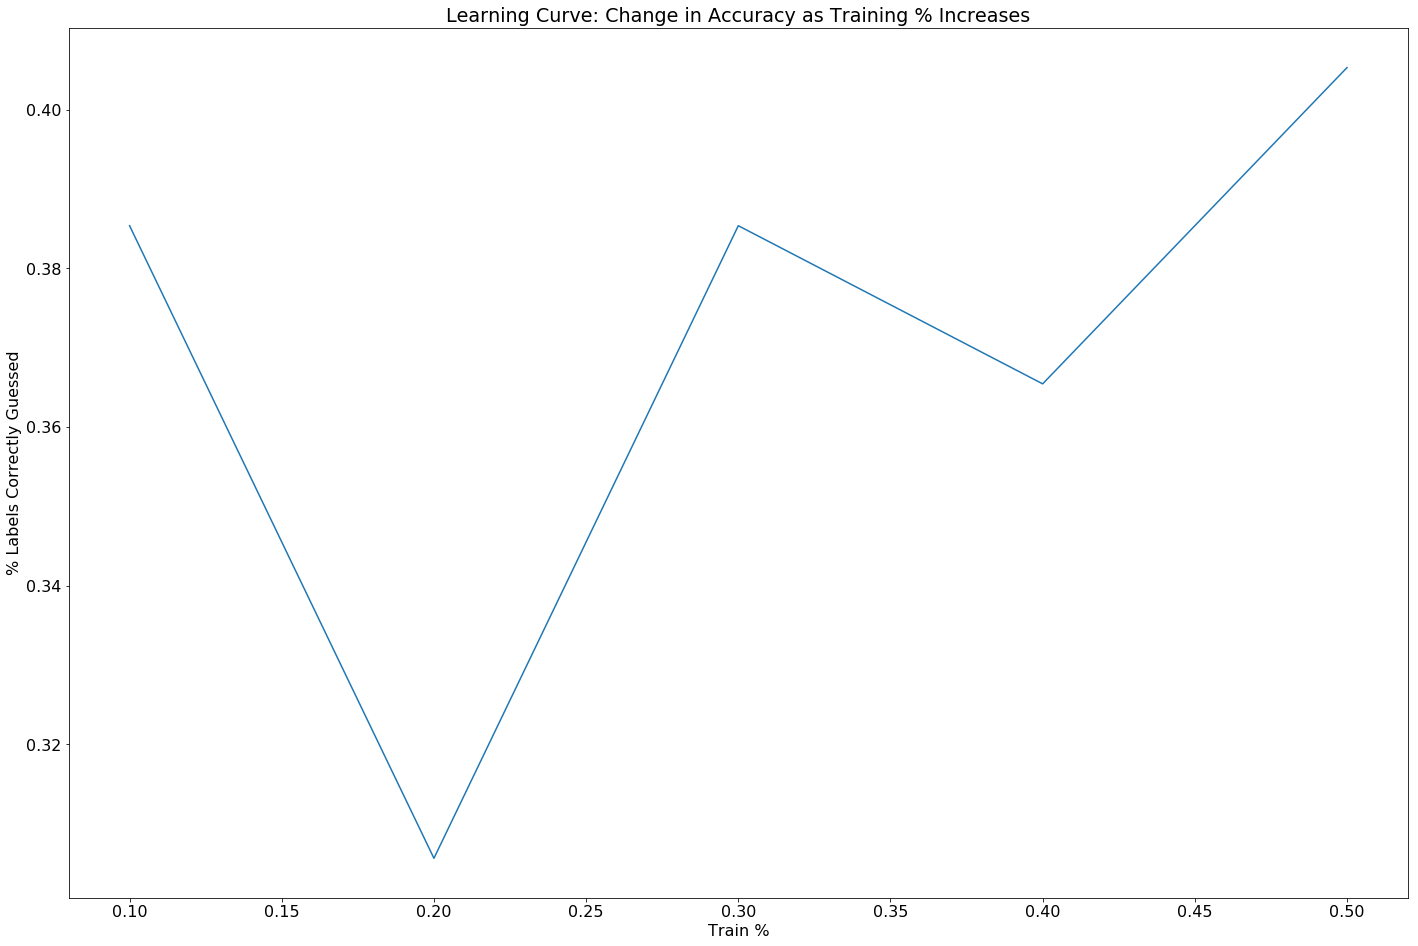

In [79]:
# Print the learning curve
print([i*100 for i in learning_curve])
plt.plot([i for i in np.arange(.1, .6, .1)], [i*1000 for i in learning_curve])
plt.title('Learning Curve: Change in Accuracy as Training % Increases')
plt.xlabel('Train %')
plt.ylabel('% Labels Correctly Guessed')
plt.show()

# Graphs for Attributes

## Scatter Plot of X and Y Coordinates

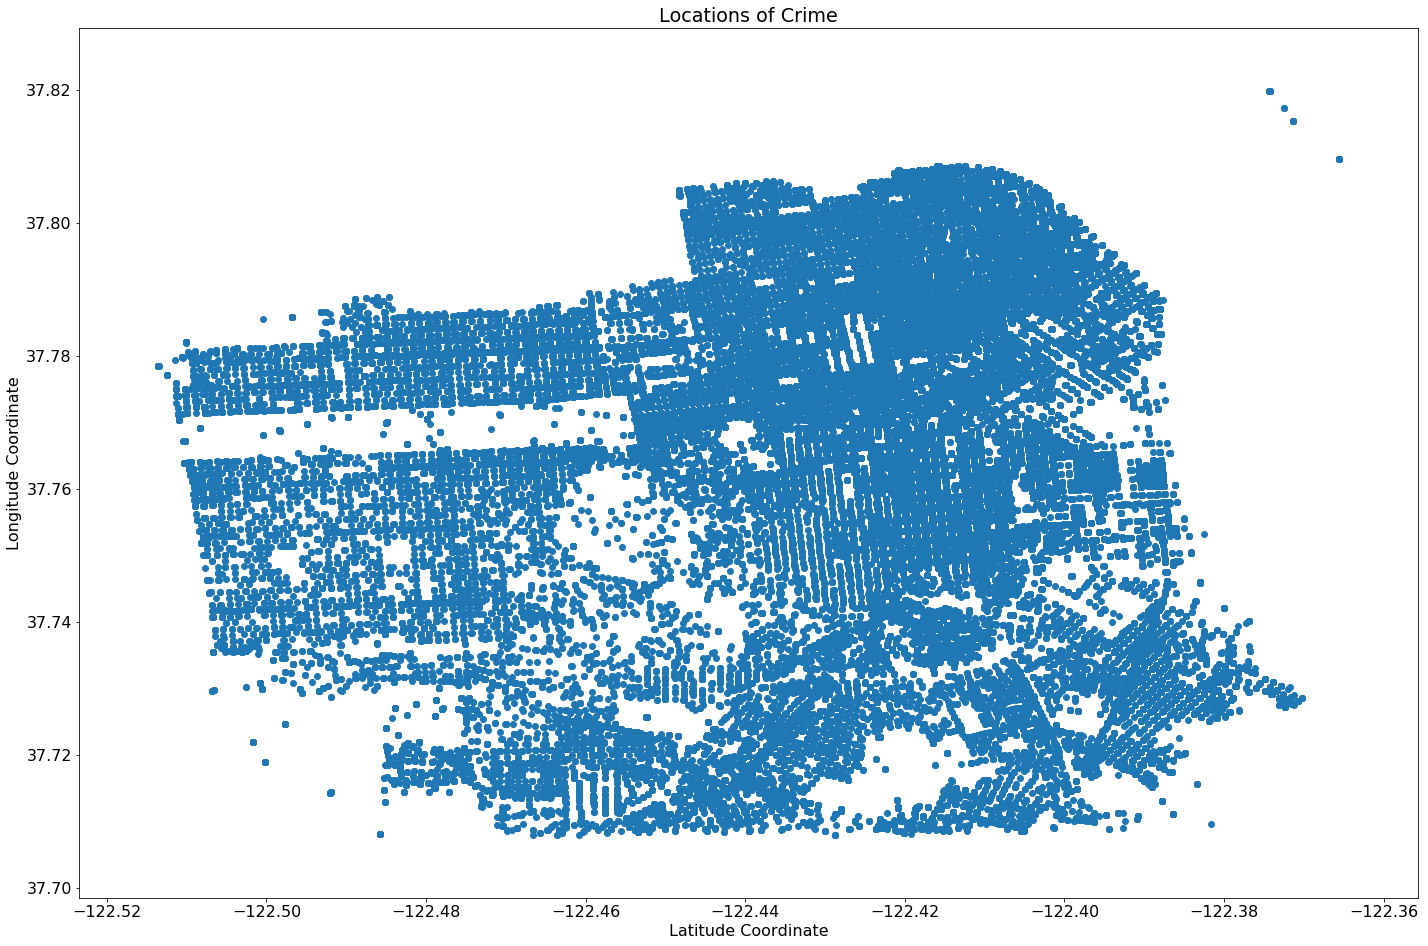

In [21]:
xy = crime_data[['X', 'Y']].values
plt.rcParams['figure.figsize'] = (24, 16)
plt.rcParams['font.size'] = 16
plt.scatter(x=[i[0] for i in xy], y=[i[1] for i in xy])
plt.title('Locations of Crime')
plt.xlabel('Latitude Coordinate')
plt.ylabel('Longitude Coordinate')
plt.show()

## Bar Graph of Number of Crimes in Each District

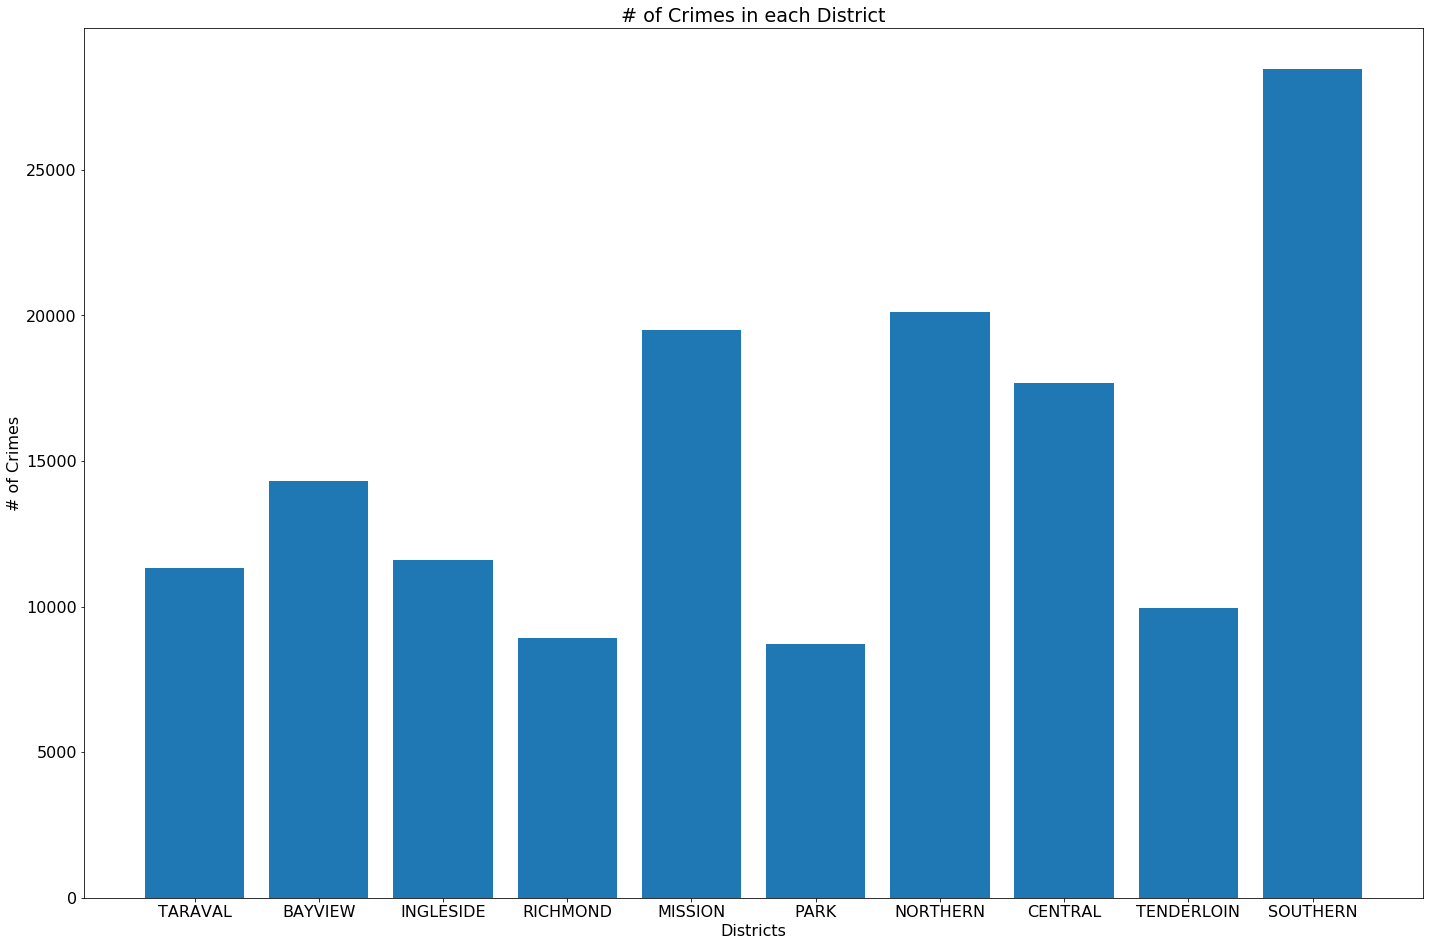

In [19]:
parse_districts = list(set([i[0] for i in crime_data[['PdDistrict']].values]))
crime_count = {i: 0 for i in parse_districts}
for element in crime_data[['PdDistrict']].values:
    crime_count[element[0]] += 1
    
x = [i for i in crime_count.keys()]
height = [i for i in crime_count.values()]
plt.bar(x, height)
plt.title('# of Crimes in each District')
plt.xlabel('Districts')
plt.ylabel('# of Crimes')
plt.show()

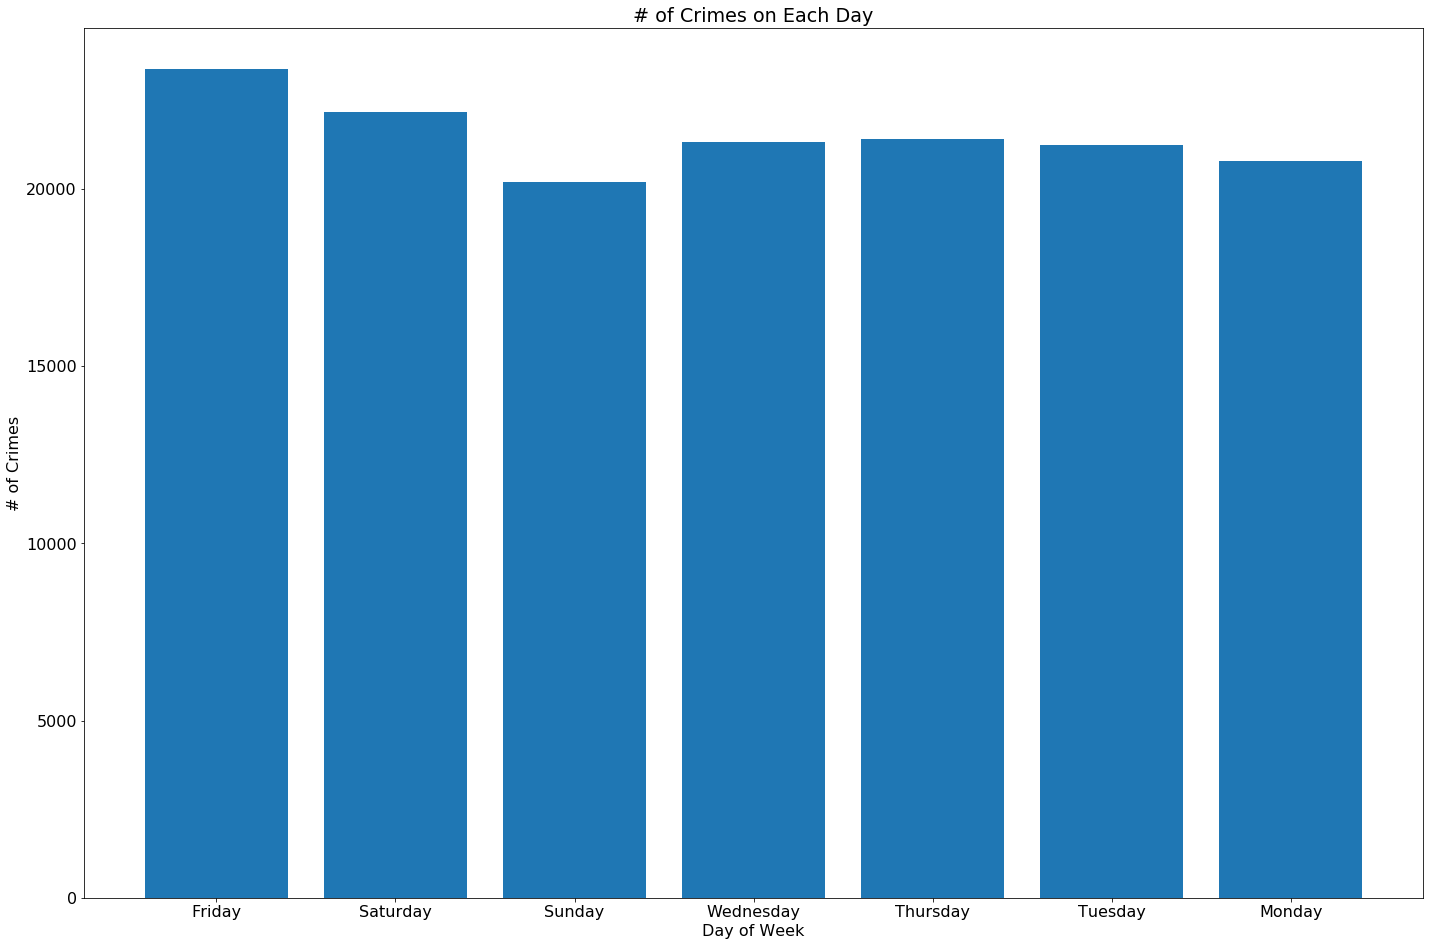

In [52]:
parse_days = list(set([i[0] for i in crime_data[['DayOfWeek']].values]))
day_crime_count = {day: 0 for day in parse_days}
for element in crime_data[['DayOfWeek']].values:
    day_crime_count[element[0]] += 1
  
x = [i for i in day_crime_count.keys()]
height = [i for i in day_crime_count.values()]
plt.bar(x, height)
plt.title('# of Crimes on Each Day')
plt.xlabel('Day of Week')
plt.ylabel('# of Crimes')
plt.show()

## Description of Attributes
There are only so many meaningful labels within the dataset. The graphs that you see above are a scatter plot of the x and y coordinates and a bar plot of the number of crimes per district in San Francisco. These are some of the only meaningful attributes to plot because when you look at attributes such as the date, incident number, and pdid, these are unique values that make sense to graph. These points are data that are numerical values that have no true numerical meaning in the context of a graph. As for the remaining attributes like some of the description and day of the week categories, this data is nominal making nothing more than a bar graph or table available to graph. 